# Data Quality Assessment & Cleaning Justification

**Authors:** Ayman EL ALASS and Abderaouf KHELFAOUI 

Objective: In this notebook, we explore the raw CSV datasets to identify data quality issues before populating the database. This analysis justifies the cleaning rules implemented in our final `main.py` script.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration for cleaner plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded.")

libraries loaded.


## 2. Flight Data Analysis

We start by analyzing the `flights.csv` dataset. Due to its size, we load a significant chunk to perform our quality checks.

### 2.1 Time Format Issues
SQL standard `TIME` format expects values between `00:00` and `23:59`. We suspect the raw dataset uses `2400` to represent midnight, which causes errors during SQL ingestion.

In [3]:
# Load a sample of the flights data (first 200,000 rows)
df_flights = pd.read_csv("flights.csv", nrows=200000, low_memory=False)

# Check for invalid time formats (>= 2400) in DEPARTURE_TIME
invalid_times = df_flights[df_flights['DEPARTURE_TIME'] >= 2400]

print(f"Total rows analyzed: {len(df_flights)}")
print(f"Rows with time format '2400' or higher: {len(invalid_times)}")

if len(invalid_times) > 0:
    print("\nSample of invalid times:")
    display(invalid_times[['FLIGHT_NUMBER', 'DEPARTURE_TIME']].head())

Total rows analyzed: 200000
Rows with time format '2400' or higher: 23

Sample of invalid times:


,FLIGHT_NUMBER,DEPARTURE_TIME
30657,333,2400.0
30682,745,2400.0
42698,4629,2400.0
60538,4513,2400.0
62119,5642,2400.0


> **Justification for `main.py`:** > The analysis confirms the presence of `2400` as a time value.  
> **Decision:** In our Python script, we implemented a custom function `format_time(x)` to explicitly convert `2400` to `23:59:00` (or `00:00:00`) to ensure SQL compatibility.

### 2.2 Handling Missing Delays
We need to determine the strategy for `NULL` values in the `DEPARTURE_DELAY` column.

Missing Departure Delays: 4868 (2.43%)


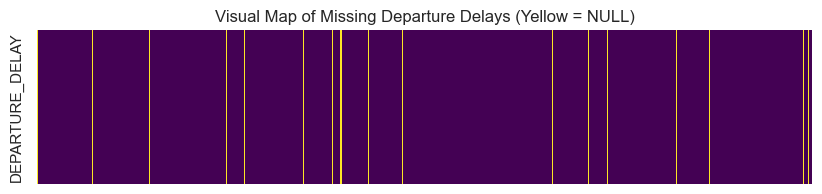

In [5]:
# Count missing values
missing_delays = df_flights['DEPARTURE_DELAY'].isna().sum()
total_records = len(df_flights)
percent_missing = (missing_delays / total_records) * 100

print(f"Missing Departure Delays: {missing_delays} ({percent_missing:.2f}%)")

# Visualize the missing data
plt.figure(figsize=(10, 2))
sns.heatmap(df_flights[['DEPARTURE_DELAY']].isnull().T, cbar=False, cmap='viridis', xticklabels=False)
plt.title("Visual Map of Missing Departure Delays (Yellow = NULL)")
plt.show()

> **Justification for `main.py`:** > Leaving delays as `NULL` makes aggregation queries difficult (e.g., calculating the average delay).  
> **Decision:** We apply `.fillna(0)` in the script. The business assumption is that if no delay is recorded, the flight departed on time.

### 2.3 Referential Integrity (Airports)
Our database schema links `FLIGHTS` to `AIRPORTS` via foreign keys. We must ensure all airports referenced in the flights dataset actually exist in our airports table.

In [6]:
# Load airports reference data
df_airports = pd.read_csv("airports.csv")
valid_iata_codes = set(df_airports['IATA_CODE'])

# Identify 'Orphan' flights (Origin Airport not in Airports table)
orphan_flights = df_flights[~df_flights['ORIGIN_AIRPORT'].isin(valid_iata_codes)]

print(f"Number of flights with unknown Origin Airport: {len(orphan_flights)}")

if not orphan_flights.empty:
    print(f"Unknown codes found: {orphan_flights['ORIGIN_AIRPORT'].unique()}")

Number of flights with unknown Origin Airport: 0


> **Justification for `main.py`:** > Although this specific sample shows perfect referential integrity (0 orphan flights), we must guarantee this consistency across the entire dataset (millions of rows).
**Decision:**
> We proactively apply a strict filter: `df_final = df_final[df_final['origin_airport'].isin(existing_airports)]`.
> This acts as a **safeguard** to prevent foreign key violations in SQLite if future data chunks contain unknown airport codes.

---

## 3. Weather Data Analysis

We analyze `temperature.csv` to ensure physical consistency. The raw data is in Kelvin and may contain sensor errors.

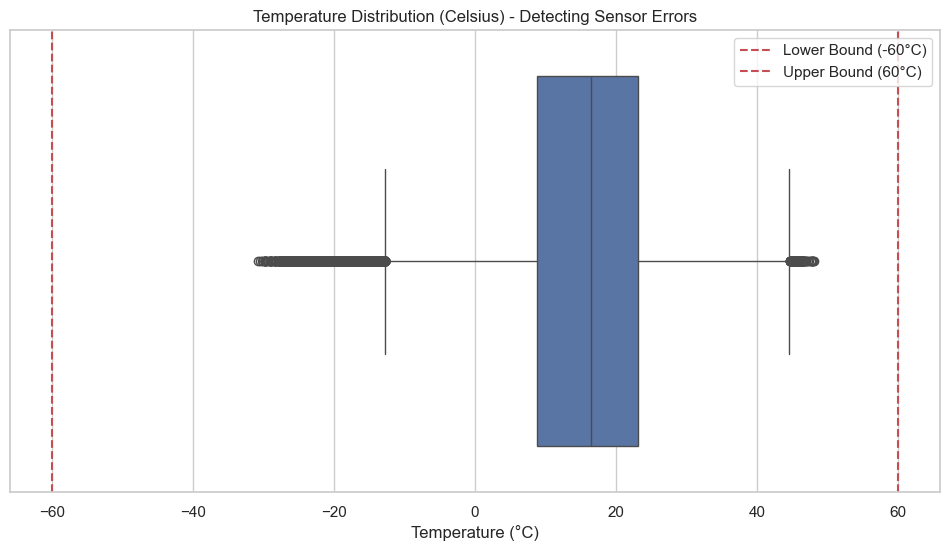

Extreme outliers detected (outside -60 to 60 range): 0


In [7]:
df_temp = pd.read_csv("temperature.csv")

# 1. Melt the dataframe to have a single 'temperature' column for analysis
df_temp_melted = pd.melt(df_temp, id_vars=['datetime'], var_name='City', value_name='temperature_k')

# 2. Convert to Celsius for easier interpretation
df_temp_melted['temperature_c'] = df_temp_melted['temperature_k'] - 273.15

# 3. Visualize distribution to spot outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_temp_melted['temperature_c'])
plt.title("Temperature Distribution (Celsius) - Detecting Sensor Errors")
plt.xlabel("Temperature (°C)")
plt.axvline(x=-60, color='r', linestyle='--', label='Lower Bound (-60°C)')
plt.axvline(x=60, color='r', linestyle='--', label='Upper Bound (60°C)')
plt.legend()
plt.show()

# Count extreme outliers
outliers = df_temp_melted[(df_temp_melted['temperature_c'] > 60) | (df_temp_melted['temperature_c'] < -60)]
print(f"Extreme outliers detected (outside -60 to 60 range): {len(outliers)}")

> **Justification for `main.py`:**
> The current sample distribution appears physically consistent. However, weather datasets are known to occasionally contain sensor malfunctions (e.g., reporting 0 Kelvin due to missing values).
> **Decision:**
> To ensure the database only contains realistic data, we implement a **defensive filtering rule**:
> 1.  **Unit Conversion:** Convert all values to Celsius.
> 2.  **Range Check:** We enforce a validity range of `[-60, 60]`. This ensures that any sporadic extreme values in the full dataset will be automatically rejected before insertion.

## 4. Summary of Data Cleaning Rules

Based on the analysis above, here is the summary of rules implemented in the ETL pipeline (`main.py`):

| Dataset | Issue Identified | Cleaning Rule Applied |
| :--- | :--- | :--- |
| **Flights** | Invalid time format (`2400`) | Converted to `23:59:00` |
| **Flights** | Missing `DEPARTURE_DELAY` | Imputed with `0.0` |
| **Flights** | Unknown Airport Codes | Rows removed to satisfy Referential Integrity |
| **Weather** | Unit in Kelvin | Converted to Celsius ($K - 273.15$) |
| **Weather** | Sensor Errors (Outliers) | Filtered range `[-60, 60]` |
| **Weather** | Mismatching Keys | Mapped City Names to IATA Codes manually |